### Imports

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_absolute_error

In [23]:
raw_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
raw_train.head()

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,color,Harvest Time,Average Daily Temperature During Growth (celcius),Average Temperature During Storage (celcius),Scoville Heat Units (SHU)
0,17.37,5.42,94.30,4.90,193.93,3.21,173.59,6.15,88.59,3.40,red,Midday,8.68,5-6,0.00
1,27.78,4.75,262.71,6.56,186.29,8.19,100.41,2.36,111.20,5.45,green,Midday,22.44,NaN,0.00
2,6.17,3.51,66.72,7.96,298.81,4.69,125.91,6.75,72.98,2.77,red,Midday,24.99,NaN,455995.06
3,6.12,6.07,51.24,4.57,39.36,2.76,143.54,5.93,63.93,1.62,yellow,Midday,13.05,NaN,0.00
4,28.58,4.84,166.51,3.07,194.07,7.01,193.76,2.85,88.19,3.99,red,Midday,27.08,NaN,0.00


In [24]:
raw_train.describe()

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,Average Daily Temperature During Growth (celcius),Scoville Heat Units (SHU)
count,999.000000,999.000000,999.000000,998.000000,999.000000,999.000000,1000.000000,999.000000,1000.000000,999.000000,1000.000000,1000.000000
mean,15.574675,6.641572,169.346406,4.619499,128.731301,4.215385,142.035180,3.283534,90.878380,3.679179,19.641960,70941.260020
std,6.267303,2.139023,123.779026,2.829503,87.270366,3.163125,72.246142,1.938264,18.724314,1.034726,6.436255,108149.917069
min,0.300000,0.100000,0.560000,0.000000,0.040000,0.010000,0.950000,0.010000,31.400000,0.850000,0.840000,0.000000
25%,11.290000,5.140000,79.020000,2.400000,55.390000,1.710000,92.290000,1.865000,78.585000,2.980000,15.397500,0.000000
50%,15.520000,6.600000,147.230000,4.280000,119.490000,3.590000,141.730000,3.140000,89.690000,3.660000,19.495000,0.000000
75%,19.900000,8.045000,227.625000,6.560000,186.845000,6.115000,192.720000,4.555000,103.200000,4.375000,23.530000,121349.617500
max,35.570000,13.620000,869.970000,14.630000,487.260000,19.020000,450.290000,9.360000,158.300000,8.250000,40.700000,527639.860000


In [25]:
print(raw_train.isnull().sum()) # view missing data


Length (cm)                                            1
Width (cm)                                             1
Weight (g)                                             1
Pericarp Thickness (mm)                                2
Seed Count                                             1
Capsaicin Content                                      1
Vitamin C Content (mg)                                 0
Sugar Content                                          1
Moisture Content                                       0
Firmness                                               1
color                                                  1
Harvest Time                                           0
Average Daily Temperature During Growth (celcius)      0
Average Temperature During Storage (celcius)         648
Scoville Heat Units (SHU)                              0
dtype: int64


In [26]:
# violin plot
#fig_violin, ax_violin = plt.subplots(nrows=3, ncols=5, figsize=(16, 9))
#plt.tight_layout(pad=3.0)

#i = 0
#for row in range(3):
    #for col in range(5):
        #sns.violinplot(ax=ax_violin[row, col], data=raw_train, x='Scoville Heat Units (SHU)', y=raw_train.columns[i], 
                       #hue='Scoville Heat Units (SHU)', split=True) # the split makes it easier to see the differenvce for edible 1 or 0
        #i += 1
        
#plt.show()

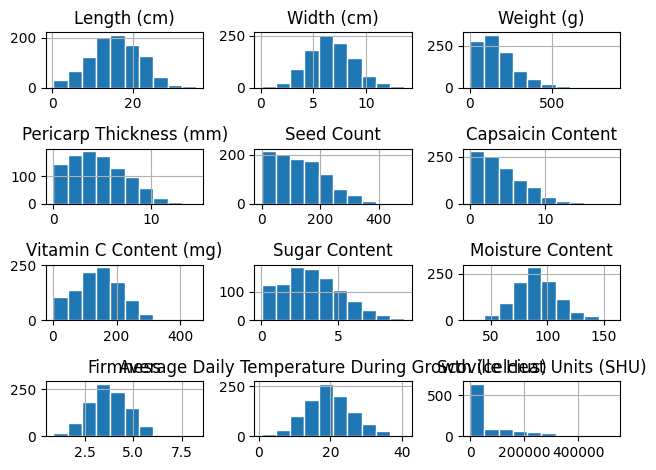

In [27]:
# Histogram 
raw_train.hist(edgecolor="white") # edgecolor makes it look nicer 
plt.tight_layout()
plt.show()

In [28]:
# drop average temperature column
train = raw_train.drop(['Average Temperature During Storage (celcius)'], axis=1)

In [29]:
# drop rows with missing data
train = train.dropna() # remove NaN values 
print(train.isnull().sum())# view if there is still missing data after removing NaN values

Length (cm)                                          0
Width (cm)                                           0
Weight (g)                                           0
Pericarp Thickness (mm)                              0
Seed Count                                           0
Capsaicin Content                                    0
Vitamin C Content (mg)                               0
Sugar Content                                        0
Moisture Content                                     0
Firmness                                             0
color                                                0
Harvest Time                                         0
Average Daily Temperature During Growth (celcius)    0
Scoville Heat Units (SHU)                            0
dtype: int64


In [30]:
# Using Z-scores to filter out the outliers. Z-score < |3|
from scipy import stats

# Assuming 'train' is your DataFrame and you want to filter outliers based on z-scores
numerical_cols = train.select_dtypes(include=np.number).columns

# Compute z-scores only on numerical columns
z_scores = stats.zscore(train[numerical_cols])

# Calculate absolute z-scores
abs_z_scores = np.abs(z_scores)

# Filter out rows where all absolute z-scores are less than 3
not_outliers = (abs_z_scores < 3).all(axis=1)

# Filter the original dataframe based on not_outliers
train = train[not_outliers]

print(f'Shape of dataset after removing outliers: {train.shape}')


Shape of dataset after removing outliers: (930, 14)


In [31]:
# Separate features and target variable
data = train.copy()
X = data.drop(columns=['Scoville Heat Units (SHU)'])
y = data['Scoville Heat Units (SHU)']

# Define preprocessing steps
numeric_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipelines
# Pipeline A: Regression Analysis with Linear Regression
pipeline_A = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

# Pipeline B: Multi-class Classification Analysis with Random Forest Regressor
pipeline_B = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', RandomForestRegressor())])

# Pipeline C: Two-step Analysis with Random Forest Classifier and Linear Regression
pipeline_C = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier()),
                             ('regressor', LinearRegression())])


In [33]:
pipelines = [pipeline_A, pipeline_B, pipeline_C]

for pipe in pipelines:
    scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
    print(f"Model: {pipe.named_steps['regressor'].__class__.__name__}")
    print("Mean MAE:", -scores.mean())


/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/met

Model: LinearRegression
Mean MAE: nan


/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/met

Model: RandomForestRegressor
Mean MAE: nan


/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/met

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 388, in _fit
    self._validate_steps()
  File "/Users/73rabann/Desktop/DAT200/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 258, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomForestClassifier()' (type <class 'sklearn.ensemble._forest.RandomForestClassifier'>) doesn't


In [ ]:
# Hyperparameters for Pipeline B (Random Forest Regressor)
param_grid_B = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Grid search for best hyperparameters
grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='neg_mean_absolute_error')
grid_search_B.fit(X, y)

print("Best MAE:", -grid_search_B.best_score_)
print("Best parameters:", grid_search_B.best_params_)
